In [ ]:
# importing the packages that will be used in this code
import numpy as np                   # for the operations with matrices and vectors
import matplotlib.pyplot as plt      # for visualizations
from scipy.stats import levy_stable  # for generating samples from S_{\alpha}(1,0,0)

The following dictionary of functions is used for building the vector $T$ for the method of projections. 

First, an array of equidistant numbers is generated, and then then the vectorized function from that dictionary is applied element-wise to that vector. The choice of this function affects the quality of the estimation.

In [ ]:
portfolio_of_functions = {}
portfolio_of_functions.update({'sin(x)       ': np.vectorize(lambda x: np.sin(x))})
portfolio_of_functions.update({'x            ': np.vectorize(lambda x: x)})
portfolio_of_functions.update({'x**2         ': np.vectorize(lambda x: x*x)})
portfolio_of_functions.update({'x**3         ': np.vectorize(lambda x: x*x*x)})
portfolio_of_functions.update({'x**4         ': np.vectorize(lambda x: x*x*x*x)})
portfolio_of_functions.update({'x**5         ': np.vectorize(lambda x: x**5)})
portfolio_of_functions.update({'min(x**2,x)  ': np.vectorize(lambda x: min(x*x,x))})
portfolio_of_functions.update({'min(x**3,x)  ': np.vectorize(lambda x: min(x*x*x,x))})
portfolio_of_functions.update({'min(x^3,x^5) ': np.vectorize(lambda x: min(x**3,x**5))})
portfolio_of_functions.update({'sqrt(x)      ': np.vectorize(lambda x: min(x*x,x))})
portfolio_of_functions.update({'cos(x)       ': np.vectorize(lambda x: np.cos(x)*(x != 0)  )})
portfolio_of_functions.update({'x*exp(-x)    ': np.vectorize(lambda x: (x>1)*x**2+x*np.exp(-x))})
portfolio_of_functions.update({'x**4*exp(-x) ': np.vectorize(lambda x: (x>1)*x**4+x*np.exp(-x))})

In [ ]:
KEY = list(portfolio_of_functions.keys())
fun = KEY[8]

Description of the functions from the following cell:

-  **A(a, T)** is used to generate the matrix $A(\alpha) = \{\exp(-|t_i+t_j|^{\alpha}) + \exp(-|t_i-t_j|^{\alpha}),\quad i,j=0,1,..,k\}$
-  **b(a, T)** is used to generate the vector $b(\alpha)=\{0\}\cup \{  -|t_j|^{\alpha}\ln(|t_j|)\exp(-|t_j|^{\alpha}),\quad j=1,2,..,k \}$. The usage of these functions enables us to formulate the following equation 
$$\sum_{v=1}^k \color{red}{a_v} \color{black}\cdot (\exp\left\{ -|t_v-t_j|^a \right\}+\exp\left\{ -|t_v+t_j|^a \right\})=-|t_j|^a \ln |t_j|\exp\left( -|t_j|^a\right)$$
for $j=1,2,...,k$, which is solved in terms of $a_v$, i.e. if $a(\alpha)=\{a_v,\quad v=1,2,...,k \}$, then $$a(\alpha)={\left( A(\alpha)\right)}^{-1} b(\alpha)$$
-  **F(X, T)** is used to calculate $$\sum_{j=1}^{n}F(T, X_j)=\left\{2, 2\sum_{j=1}^N\cos(t_1 X_j), 2\sum_{j=1}^N\cos(t_2 X_j), ..., 2\sum_{j=1}^N\cos(t_k X_j) \right\}.$$
The inputs of this function are as follows: $X$ is the vector of observations and $T$ is the vector of the $t_j,\quad j=1,2,...,\mathrm{len}(T)$.
-  **projection(FX, T, a)** is used to calculate 
$$\left( (A(\alpha))^{-1}\cdot b(\alpha) \right)^{\top} \frac{1}{n}\sum_{j=1}^{n}F(T, X_j)$$
-  **fisher_info(T, a)** is used to calculate the approximation of the Fisher information of the parameter $\alpha$: if $k$ is the length of $T$, then $$I_k(\alpha) = \left( (A(\alpha))^{-1}\cdot b(\alpha) \right)^{\top} \cdot b(\alpha),$$ and $$\lim_{k \longrightarrow \infty} I_k(\alpha) = I(\alpha).$$

In [ ]:
def A(a, T):
    n = T.shape[0]
    A, B = np.meshgrid(T, T)
    matrix = np.exp(-abs(A + B)**a) + np.exp(-abs(A - B)**a)
    return matrix

def B(a, T):  
    T = np.array(T, dtype=np.float64)
    T[T == 0] = np.finfo(np.float64).eps
    y = -abs(T)**a * np.log(abs(T)) * np.exp(-abs(T)**a)
    return y

def F(X, T):
    X1 = np.outer(X, T)
    Y1 = np.cos(X1)
    FX = np.mean(Y1, axis=0)
    return 2*FX

def projection(FX, T, a):
    return abs(np.dot(np.dot(np.linalg.inv(A(a, T)), B(a, T)), FX))

def fisher_info(T, a):
    return abs(np.dot(np.dot(np.linalg.inv(A(a, T)), B(a, T)), B(a, T)))

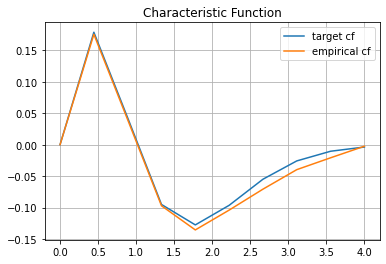

In [ ]:
alpha = 1.5
N = 5000000
delta = 0.05

T = np.linspace(0, 4, 10)


X1 = levy_stable.rvs(alpha, 0, size=N)
X0 = levy_stable.rvs(alpha - delta, 0, size=N)

def cf(t, alpha):
    return np.exp(-(abs(t))**alpha)
def d_cf(t, alpha):
    if t == 0:
      return 0
    else:
      return -(abs(t))**alpha*np.log(abs(t))*cf(t, alpha)

ecf = []
tcf  = []
d_ecf = []
d_tcf = []
for t in T:
    ecf.append(np.mean(np.cos(t*X1)))
    tcf.append(cf(t, alpha))
    d_ecf.append( ( np.mean(np.cos(t*X1)) - np.mean(np.cos(t*X0))  )/delta )
    d_tcf.append(d_cf(t, alpha))

plt.plot(T, d_tcf)
plt.plot(T, d_ecf)
plt.grid()
plt.legend(['target cf', 'empirical cf'])
plt.title('Characteristic Function')
plt.show()

In [ ]:
def A_emp(T, a, N):
    X1 = levy_stable.rvs(a, 0, size=N)
    A, B = np.meshgrid(T, T)
    for t1 in range(len(T)):
        for t2 in range(len(T)):
            A[t1, t2] = np.mean(np.cos((T[t1] + T[t2])*X1)) + np.mean(np.cos((T[t1] - T[t2])*X1))
    return A

def B_emp(a, T, N, delta):
    X1 = levy_stable.rvs(a, 0, size=N)
    X0 = levy_stable.rvs(a - delta, 0, size=N) 
    d_ecf = []
    for t in T:
        d_ecf.append( ( np.mean(np.cos(t*X1)) - np.mean(np.cos(t*X0))  )/delta )
    return np.array(d_ecf) 

def F(X, T):
    X1 = np.outer(X, T)
    Y1 = np.cos(X1)
    FX = np.mean(Y1, axis=0)
    return 2*FX

# def projection_vectot_emp(T, a):
#     return np.dot(np.linalg.inv(A_emp(a, T)), B_emp(a, T))

# def projection_emp(FX, T, a):
#     return abs(np.dot(np.dot(np.linalg.inv(A(a, T)), B(a, T)), FX))

# def fisher_info_emp(T, a):
#     return abs(np.dot(np.dot(np.linalg.inv(A(a, T)), B(a, T)), B(a, T)))

In [ ]:
T = np.arange(0, 2, 0.4)
T = portfolio_of_functions[fun](T)
# if max(T)<0.999:
#   T[-1] = 0.999

In [ ]:
Alphas = np.linspace(1.5, 1.99, 20)
Beta_Vect0 = {}
A_matr0 = {}

N_M = 100000
N_V = 10*10**6

for a in Alphas:
    A_M = A(a, T)
    A_matr0.update({a: A_M})
    #print(f"For a = {a}, matrix is computed")
    B_V = B(a, T)
    Beta_Vect0.update({a: B_V})
    #print(f"For a = {a}, vector is computed")
    #print('------------------------------------')

In [ ]:

Beta_Vect = {}
A_matr = {}

N_M = 50000000
N_V = 50*10**6

for a in Alphas:
    A_M = A_emp(T, a, N_M)
    A_M0 = A(a, T)
    A_matr.update({a: A_M})
    max_abs_A = np.max(np.abs(A_M - A_M0))    
    print(f"For a = {a}, matrix is computed")
    print(f"max deviation = {max_abs_A}")
    B_V = B_emp(a, T, N_V, 0.05)
    B_V0 = B(a, T)
    Beta_Vect.update({a: B_V})
    print(f"For a = {a}, vector is computed")
    print(f"Max deviation is { max(np.abs(B_V - B_V0)) }")
    print('------------------------------------')

For a = 1.5, matrix is computed
max deviation = 0.00021357201444272
For a = 1.5, vector is computed
Max deviation is 0.006098776137229894
------------------------------------
For a = 1.5257894736842106, matrix is computed
max deviation = 0.00018691861035960433
For a = 1.5257894736842106, vector is computed
Max deviation is 0.007986178158065068
------------------------------------
For a = 1.551578947368421, matrix is computed
max deviation = 0.00020804194582391133
For a = 1.551578947368421, vector is computed
Max deviation is 0.005169397867210768
------------------------------------
For a = 1.5773684210526315, matrix is computed
max deviation = 0.00015251832838747426
For a = 1.5773684210526315, vector is computed
Max deviation is 0.0066655089876757
------------------------------------
For a = 1.6031578947368421, matrix is computed
max deviation = 0.00014458409515549775
For a = 1.6031578947368421, vector is computed
Max deviation is 0.004536452382617129
----------------------------------

In [ ]:
def projection_vectors_emp(A_matr, Beta_Vect):
    Alphas = list(A_matr.keys())
    Fisher_Info = []
    projection_vectors = {}
    invers_matrices = {}
    for a in Alphas: 
        A1 = A_matr[a]
        b1 = Beta_Vect[a]
        A1_inv = np.linalg.inv(A1)
        invers_matrices.update({a: A1_inv})
        projection_vectors.update({a: np.dot(A1_inv, b1)})
        Fisher_Info.append(np.dot(projection_vectors[a], b1 ))
    return invers_matrices, projection_vectors, Fisher_Info

In [ ]:
invers_matrices, projection_vectors, Fisher = projection_vectors_emp(A_matr, Beta_Vect)

In [ ]:
KEYS = list(A_matr.keys())

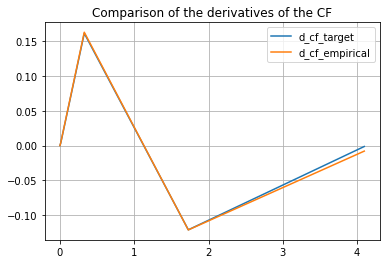

In [ ]:
k1 = 3
plt.plot(T, Beta_Vect0[KEYS[k1]])
plt.plot(T, Beta_Vect[KEYS[k1]])
plt.grid()
plt.legend(['d_cf_target', 'd_cf_empirical'])
plt.title('Comparison of the derivatives of the CF')
plt.show()

In [ ]:
invers_matrices, projection_vectors, Fisher = projection_vectors_emp(A_matr, Beta_Vect)
invers_matrices0, projection_vectors0, Fisher0 = projection_vectors_emp(A_matr0, Beta_Vect0)

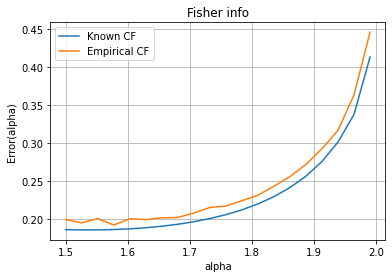

In [ ]:
plt.plot(Alphas, Fisher0)
plt.plot(Alphas, Fisher)
plt.grid()
plt.legend(['Known CF', 'Empirical CF'])
plt.xlabel('alpha')
plt.ylabel('Error(alpha)')
plt.title('Fisher info')
plt.show()

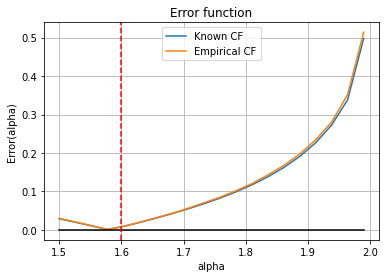

In [ ]:
N = 10000
alpha = 1.6
X = levy_stable.rvs(alpha, 0, size=N)
FX = F(X, T)

y = []
y1 = []
for k in KEYS:
    y.append(np.dot(FX, projection_vectors0[k]))
    y1.append(np.dot(FX, projection_vectors[k]))
plt.plot(Alphas, np.abs(y))
plt.plot(Alphas, np.abs(y1))
plt.plot(Alphas, np.array(y)*0,'k')
plt.axvline(x=alpha, color='red', linestyle='--')
plt.grid()
plt.legend(['Known CF', 'Empirical CF'])
plt.title('Error function')
plt.xlabel('alpha')
plt.ylabel('Error(alpha)')
plt.show()


In [ ]:
def truncate_string(num):
    num = round(num, 4)
    num = str(num)
    new_string = num[:6]
    return new_string + "0" * (6 - len(new_string))

In [ ]:
N = 100000
num_samples = 50

Avg_Alpha_Estimates_t = []
Avg_Alpha_Estimates_e = []
Std_Alpha_Estimates_t = []
Std_Alpha_Estimates_e = []

for alpha in Alphas:
    Ests_t = []
    Ests_e = []
    for _ in range(num_samples):

        X = levy_stable.rvs(alpha, 0, size=N)
        FX = F(X, T)

        y_e = []
        y_t = []

        for k in KEYS:
            y_t.append(abs(np.dot(FX, projection_vectors0[k])))
            y_e.append(abs(np.dot(FX, projection_vectors[k])))    

        argmin_t = np.argmin(y_t) 
        argmin_e = np.argmin(y_e) 

        alpha_est_t = Alphas[argmin_t]
        alpha_est_e = Alphas[argmin_e]

        Ests_t.append(alpha_est_t)
        Ests_e.append(alpha_est_e)
    Avg_Alpha_Estimates_t.append(np.mean(Ests_t))
    Std_Alpha_Estimates_t.append(np.std(Ests_t))
    Avg_Alpha_Estimates_e.append(np.mean(Ests_e))
    Std_Alpha_Estimates_e.append(np.std(Ests_e))
    print(f"Target alpha = {truncate_string(alpha)}, avg alpha_MLP = {truncate_string(np.mean(Ests_t))}, avg alpha_MLP_e = {truncate_string(np.mean(Ests_e))} ")
    


Target alpha = 1.5000, avg alpha_MLP = 1.5005, avg alpha_MLP_e = 1.5005 
Target alpha = 1.5258, avg alpha_MLP = 1.5248, avg alpha_MLP_e = 1.5248 
Target alpha = 1.5516, avg alpha_MLP = 1.5516, avg alpha_MLP_e = 1.5516 
Target alpha = 1.5774, avg alpha_MLP = 1.5774, avg alpha_MLP_e = 1.5774 
Target alpha = 1.6032, avg alpha_MLP = 1.6032, avg alpha_MLP_e = 1.6032 
Target alpha = 1.6289, avg alpha_MLP = 1.6289, avg alpha_MLP_e = 1.6289 
Target alpha = 1.6547, avg alpha_MLP = 1.6553, avg alpha_MLP_e = 1.6547 
Target alpha = 1.6805, avg alpha_MLP = 1.6810, avg alpha_MLP_e = 1.6810 
Target alpha = 1.7063, avg alpha_MLP = 1.7068, avg alpha_MLP_e = 1.7068 
Target alpha = 1.7321, avg alpha_MLP = 1.7321, avg alpha_MLP_e = 1.7321 
Target alpha = 1.7579, avg alpha_MLP = 1.7584, avg alpha_MLP_e = 1.7584 
Target alpha = 1.7837, avg alpha_MLP = 1.7837, avg alpha_MLP_e = 1.7837 
Target alpha = 1.8095, avg alpha_MLP = 1.8095, avg alpha_MLP_e = 1.8095 
Target alpha = 1.8353, avg alpha_MLP = 1.8358, avg 

In [ ]:
def visualize_samples(values_of_alpha, Means, upper_line, lower_line, N):      
      fig = plt.figure(figsize=(12, 14))
      plt.plot(values_of_alpha, Means, 'g-o')
      plt.plot(values_of_alpha, upper_line, 'b')
      plt.plot(values_of_alpha, lower_line, 'r')
      plt.plot(values_of_alpha, values_of_alpha, 'k')
      plt.fill_between(values_of_alpha, upper_line, lower_line, color='gray', alpha=0.5)
      plt.grid()
      plt.xlabel('alpha')
      plt.ylabel('alpha_estimate')
      plt.title(r'Demonstration of the average estimate and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))
      plt.legend(['$\mu$,  $\mu = avg(alpha\_sample)$','$ \mu + 3*\sigma$,  $\sigma = std(alpha\_sample)$', '$\mu - 3*\sigma$',  'real_alpha'])

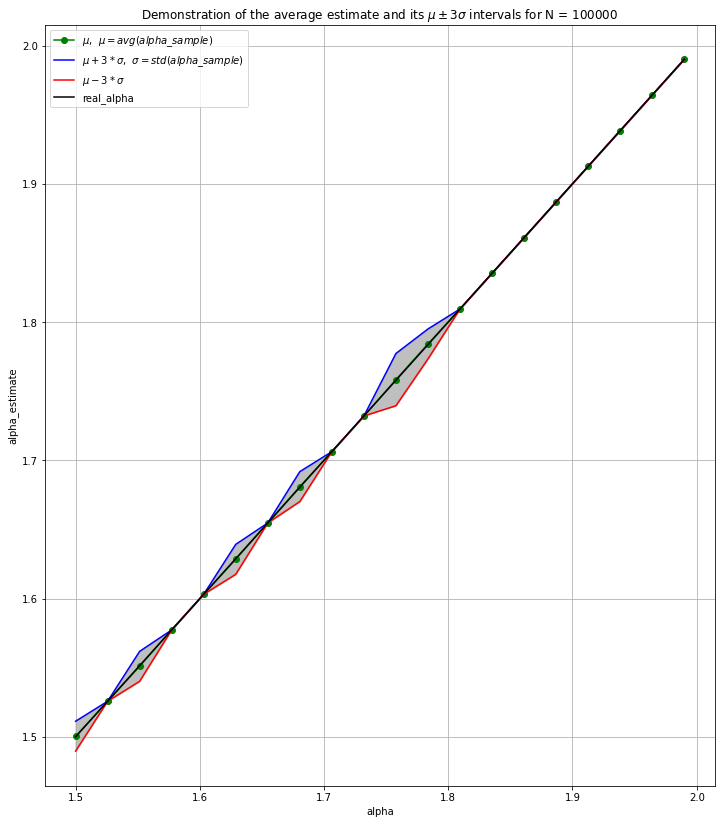

In [ ]:
values_of_alpha = Alphas
Means = Avg_Alpha_Estimates_t
upper_line = np.array(Avg_Alpha_Estimates_t) + 3*np.array(Std_Alpha_Estimates_t)
lower_line = np.array(Avg_Alpha_Estimates_t) - 3*np.array(Std_Alpha_Estimates_t)
visualize_samples(values_of_alpha, Means, upper_line, lower_line, N)

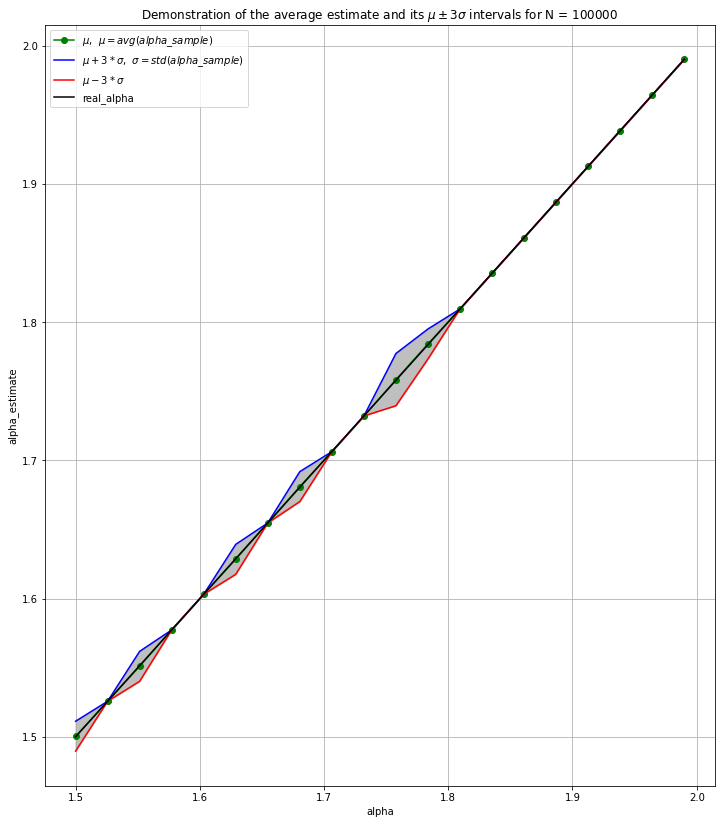

In [ ]:
values_of_alpha = Alphas
Means = Avg_Alpha_Estimates_e
upper_line = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means, upper_line, lower_line, N)

In [ ]:
Alphas

array([1.5       , 1.52578947, 1.55157895, 1.57736842, 1.60315789,
       1.62894737, 1.65473684, 1.68052632, 1.70631579, 1.73210526,
       1.75789474, 1.78368421, 1.80947368, 1.83526316, 1.86105263,
       1.88684211, 1.91263158, 1.93842105, 1.96421053, 1.99      ])

In [ ]:
N = 150
num_samples = 50

Avg_Alpha_Estimates_t = []
Avg_Alpha_Estimates_e = []
Std_Alpha_Estimates_t = []
Std_Alpha_Estimates_e = []

for alpha in Alphas:
    Ests_t = []
    Ests_e = []
    for _ in range(num_samples):

        X = levy_stable.rvs(alpha, 0, size=N)
        FX = F(X, T)

        y_e = []
        y_t = []

        for k in KEYS:
            y_t.append(abs(np.dot(FX, projection_vectors0[k])))
            y_e.append(abs(np.dot(FX, projection_vectors[k])))    

        argmin_t = np.argmin(y_t) 
        argmin_e = np.argmin(y_e) 

        alpha_est_t = Alphas[argmin_t]
        alpha_est_e = Alphas[argmin_e]

        Ests_t.append(alpha_est_t)
        Ests_e.append(alpha_est_e)
    Avg_Alpha_Estimates_t.append(np.mean(Ests_t))
    Std_Alpha_Estimates_t.append(np.std(Ests_t))
    Avg_Alpha_Estimates_e.append(np.mean(Ests_e))
    Std_Alpha_Estimates_e.append(np.std(Ests_e))
    print(f"Target alpha = {truncate_string(alpha)}, avg alpha_MLP = {truncate_string(np.mean(Ests_t))}, avg alpha_MLP_e = {truncate_string(np.mean(Ests_e))} ")

Target alpha = 1.5000, avg alpha_MLP = 1.5603, avg alpha_MLP_e = 1.5614 
Target alpha = 1.5258, avg alpha_MLP = 1.5547, avg alpha_MLP_e = 1.5542 
Target alpha = 1.5516, avg alpha_MLP = 1.6088, avg alpha_MLP_e = 1.6078 
Target alpha = 1.5774, avg alpha_MLP = 1.5897, avg alpha_MLP_e = 1.5897 
Target alpha = 1.6032, avg alpha_MLP = 1.6006, avg alpha_MLP_e = 1.6037 
Target alpha = 1.6289, avg alpha_MLP = 1.6480, avg alpha_MLP_e = 1.6485 
Target alpha = 1.6547, avg alpha_MLP = 1.6945, avg alpha_MLP_e = 1.6939 
Target alpha = 1.6805, avg alpha_MLP = 1.6872, avg alpha_MLP_e = 1.6867 
Target alpha = 1.7063, avg alpha_MLP = 1.7084, avg alpha_MLP_e = 1.7089 
Target alpha = 1.7321, avg alpha_MLP = 1.7208, avg alpha_MLP_e = 1.7213 
Target alpha = 1.7579, avg alpha_MLP = 1.7522, avg alpha_MLP_e = 1.7533 
Target alpha = 1.7837, avg alpha_MLP = 1.8084, avg alpha_MLP_e = 1.8084 
Target alpha = 1.8095, avg alpha_MLP = 1.7801, avg alpha_MLP_e = 1.7796 
Target alpha = 1.8353, avg alpha_MLP = 1.8415, avg 

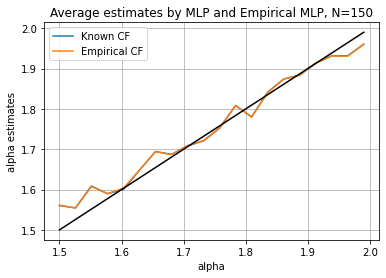

In [ ]:
plt.plot(values_of_alpha, Avg_Alpha_Estimates_t)
plt.plot(values_of_alpha, Avg_Alpha_Estimates_e)
plt.plot(values_of_alpha, values_of_alpha, 'k')
plt.grid()
plt.title('Average estimates by MLP and Empirical MLP, N=150')
plt.legend(['Known CF', 'Empirical CF'])
plt.xlabel('alpha')
plt.ylabel('alpha estimates')
plt.show()

Text(0, 0.5, 'diff')

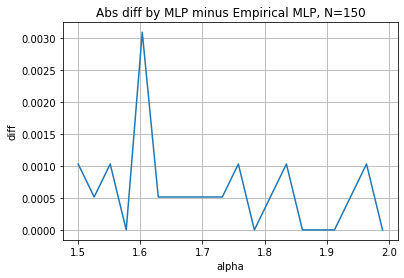

In [ ]:
plt.plot(values_of_alpha, np.abs(np.array(Avg_Alpha_Estimates_t) - np.array(Avg_Alpha_Estimates_e)))
plt.title('Abs diff by MLP minus Empirical MLP, N=150')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('diff')

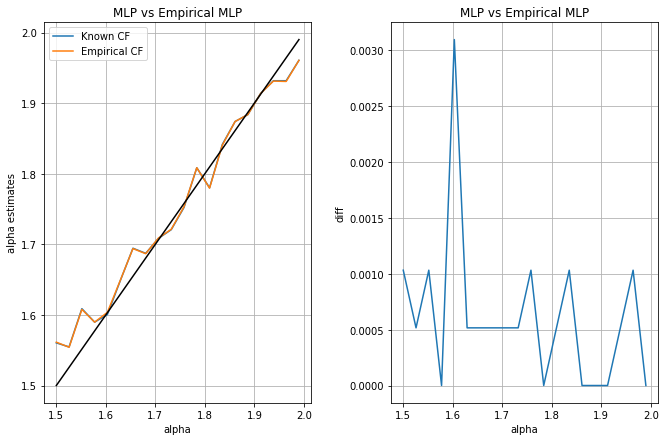

In [ ]:
# First plot

fig = plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.plot(values_of_alpha, Avg_Alpha_Estimates_t)
plt.plot(values_of_alpha, Avg_Alpha_Estimates_e)
plt.plot(values_of_alpha, values_of_alpha, 'k')
plt.grid()
plt.title('MLP vs Empirical MLP')
plt.legend(['Known CF', 'Empirical CF'])
plt.xlabel('alpha')
plt.ylabel('alpha estimates')

# Second plot
plt.subplot(122)
plt.plot(values_of_alpha, np.abs(np.array(Avg_Alpha_Estimates_t) - np.array(Avg_Alpha_Estimates_e)))
plt.title('MLP vs Empirical MLP')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('diff')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

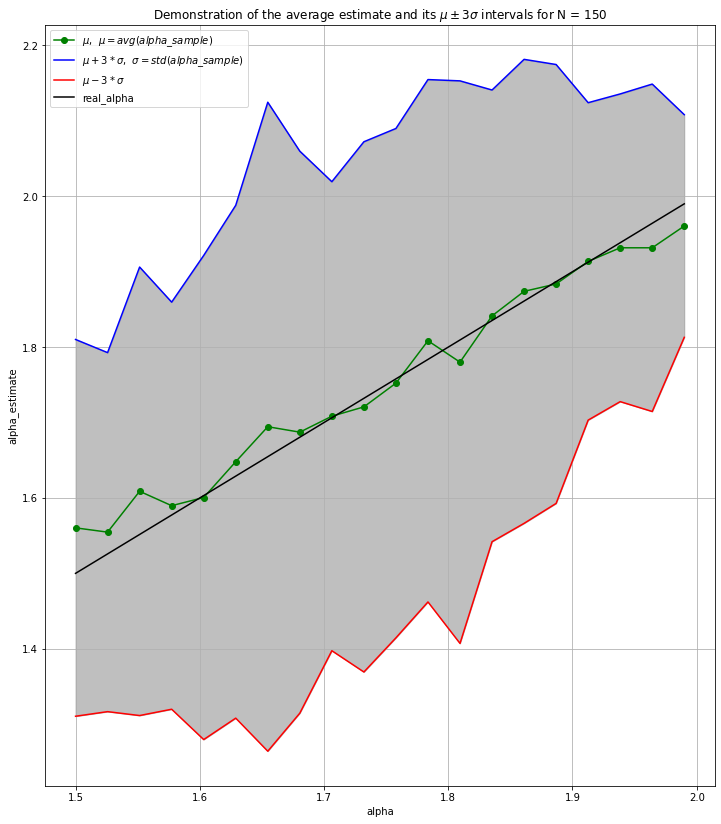

In [ ]:
values_of_alpha = Alphas
Means = Avg_Alpha_Estimates_t
upper_line = np.array(Avg_Alpha_Estimates_t) + 3*np.array(Std_Alpha_Estimates_t)
lower_line = np.array(Avg_Alpha_Estimates_t) - 3*np.array(Std_Alpha_Estimates_t)
visualize_samples(values_of_alpha, Means, upper_line, lower_line, N)

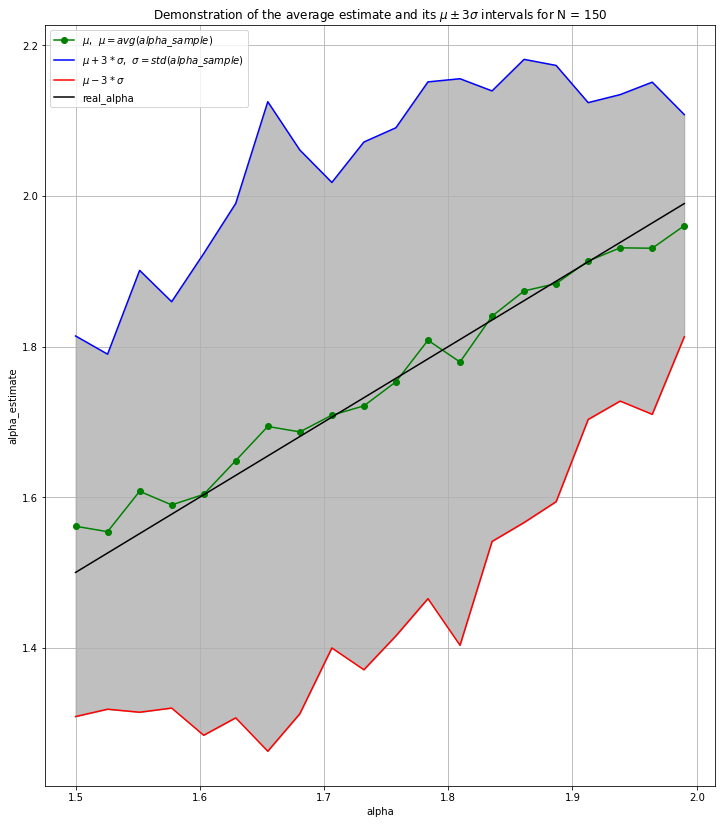

In [ ]:
values_of_alpha = Alphas
Means = Avg_Alpha_Estimates_e
upper_line = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means, upper_line, lower_line, N)